In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
CHROMADB_API_KEY=os.getenv("CHROMADB_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=GROQ_API_KEY
os.environ["CHROMADB_API_KEY"]=CHROMADB_API_KEY
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [2]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import JSONLoader
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter 

### jq_schema = """
    .[] |
    {
        content: (
            "Faculty: " + .faculty + "\\n" +
            "Subject: " + (.subject // "N/A") + "\\n" +
            "Branch: " + (.branch // "N/A") + "\\n" +
            "Year: " + (.year_teach // "N/A") + "\\n" +
            "Location: " + (.location // "N/A") + "\\n" +
            "Advantages: " + (.advantages // "N/A") + "\\n" +
            "Disadvantages: " + (.disadvantages // "N/A") + "\\n" +
            "Achievements: " + .achievements
        ),
        metadata: {
            faculty: .faculty
        }
    }
"""
###

In [3]:
# Loading the database of faculty present in Teacher_data.json
# Initiating the loader 

file_path="C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json"
loader=JSONLoader(
    file_path= file_path, #takes the file path of data
    #jq_schema provide schema of the whole database
    jq_schema = """
.[] | {
    content: (
        "Faculty: " + .faculty + "\\n" +
        "Subjects: " + (.subject | join(", ")) + "\\n" +
        "Branch: " + .branch + "\\n" +
        "Years Taught: " + (.year_teach | join(", ")) + "\\n" +
        "Location: " + .location + "\\n" +
        "Advantages: " + .advantages + "\\n" +
        "Disadvantages: " + .disadvantages + "\\n" +
        "Achievements: " + (.achievements | join("; "))
    ),
    metadata: {
        faculty: .faculty,
        branch: .branch,
        location: .location
    }
}
""",content_key="content"
)
#loader is the list of dictionary
data=loader.load()
print(type(data))
print(len(data))
print(data[1])
print(data)
print(data[0].page_content)
print(data[0].metadata)

<class 'list'>
60
page_content='Faculty: Mr. Abhishek Malviya
Subjects: 
Branch: 
Years Taught: 
Location: 
Advantages: 
Disadvantages: 
Achievements: Nexus Connecting Hoomans, Rivista Italiana di Filosofia Analitica Junior, ESCI 2023 Virtual U; Robust Voice Assistant using Gaussian Mixture Model, Journal of Harbin Engineering University, Scopus-2023' metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 2}
[Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 1}, page_content='Faculty: Mr. Abdul Zeeshan\nSubjects: \nBranch: \nYears Taught: \nLocation: \nAdvantages: \nDisadvantages: \nAchievements: A research paper presented in 3rdIEEE International Conference on Power Electronics & IOT Applications in Renewable Energy and its Control (PARC 2024), titled, "Fuzzy/ANFIS control of DFIG based wind energy conversion system under the condition of voltage sag on grid in one phase" on 23r

In [4]:
# Creating chunks of the json file which is now "data"
# Doing RecursiveCharacterTextSplitter on the data to get the semantic search reasonable 
# so to get the full word not the half words
splitter = RecursiveCharacterTextSplitter(chunk_size=300,chunk_overlap=50)
splitted_docs=splitter.split_documents(data)

In [5]:
print(type(splitted_docs))
print(len(splitted_docs))
print(splitted_docs)
print(splitted_docs[0])
print(splitted_docs[0].metadata)
print(splitted_docs[0].page_content)

<class 'list'>
194
[Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 1}, page_content='Faculty: Mr. Abdul Zeeshan\nSubjects: \nBranch: \nYears Taught: \nLocation: \nAdvantages: \nDisadvantages:'), Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 1}, page_content='Achievements: A research paper presented in 3rdIEEE International Conference on Power Electronics & IOT Applications in Renewable Energy and its Control (PARC 2024), titled, "Fuzzy/ANFIS control of DFIG based wind energy conversion system under the condition of voltage sag on grid in one phase" on'), Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 1}, page_content='condition of voltage sag on grid in one phase" on 23rd February 2024, organized by GLA University, Mathura, Uttar Pradesh, India'), Document(metadata={'source': 'C:\\Users\\HVS\\One

In [6]:
# loading the llm model here loading the groq llm model here and using gemma2-9b-it
# using embedder from hugging face using sentence transformer(BERT ARCHITECTURE) using all-MiniLM-L6-v2

from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

model_name="sentence-transformers/all-MiniLM-L6-v2"
embeddings=HuggingFaceEmbeddings(model=model_name)

model_name="gemma2-9b-it"
llm = ChatGroq(model=model_name,temperature=0.6)
llm = init_chat_model("groq:gemma2-9b-it")


c:\Users\HVS\OneDrive\Desktop\Chatbot\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
result=embeddings.embed_query("hello world")
print(len(result))


384


In [8]:
# storing the embedded data to our vector storage using ChromaDB and embedding using is hugging face embedder sentence transformer
from langchain.vectorstores import Chroma

vector_store=Chroma.from_documents(documents=splitted_docs,
                                      embedding=embeddings,
                                      persist_directory="./Data")
print(type(vector_store))

retriever=vector_store.as_retriever(search_type="similarity",search_kwargs={'k':3})

<class 'langchain_community.vectorstores.chroma.Chroma'>


In [9]:
print(retriever)
retriever.invoke("kumar dwivedi")

tags=['Chroma', 'HuggingFaceEmbeddings'] vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000002A8D6D281A0> search_kwargs={'k': 3}


[Document(metadata={'seq_num': 56, 'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json'}, page_content="Location: D Block Ground Floor\nAdvantages: Vijay kumar Dwivedi is a teacher whom Students prefer them the best teacher in machine learning,The best part about him that whenever you call him he'll pick up your call solve your problems."),
 Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 56}, page_content='Faculty: Mr. Vijay Kumar Dwivedi\nSubjects: Machine Learning, Deep Learning, Artificial Intelligence\nBranch: Computer Science and Engineering\nYears Taught: 3rd, 4th\nLocation: D Block Ground Floor'),
 Document(metadata={'source': 'C:\\Users\\HVS\\OneDrive\\Desktop\\Chatbot\\Data\\Teacher_data.json', 'seq_num': 7}, page_content='Singh, Amit Kumar Singh, Abhishek Kumar Tripathi and Prateek Pandey')]

In [10]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="UGI_TOOLS",
    description="You are the UGI expert and knows everything about the all faculty members information from minute to minute detail.you provide the faculty informations on the basis of these details: faculty_name,subject they teach,which branch of engineering they teach,to which year of students they teach,where they sit in the college at which place means their location in the college,the advantages of their teaching,their disadvantages of teaching,the achievements they have got in past these years and here the achievements are research paper,conference paper and patents.so you will help students to pick best faculty on their desired query."
    
)

print(type(retriever_tool))

<class 'langchain_core.tools.simple.Tool'>


In [11]:
retriever_tool.invoke({"query":"which teacher is best in machine learning "})

'Location: D Block Ground Floor\nAdvantages: Vijay kumar Dwivedi is a teacher whom Students prefer them the best teacher in machine learning,The best part about him that whenever you call him he\'ll pick up your call solve your problems.\n\nFaculty: Mr. Vijay Kumar Dwivedi\nSubjects: Machine Learning, Deep Learning, Artificial Intelligence\nBranch: Computer Science and Engineering\nYears Taught: 3rd, 4th\nLocation: D Block Ground Floor\n\nMachine Learning Approaches for Students\' Performance Prediction using Demographical Features" in Springer LNNS; Published a research paper entitled "Exploratory Data Analysis (EDA) based on Demographical Features for Students\' Performance Prediction" in Taylor and Frances (SCOPUS Indexed);'

In [12]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages



class State(TypedDict):
    # State here is like a message passing from one node to another
    # Messages have the type list. the add_messages is a function to append messages.
    # annotation defines how the state key should be updated here it is appending like a list.
    # here in this case it appends message to the list rather than updating with help of add_messages function.
    messages: Annotated[list, add_messages]

#node functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

def tool_calling_llm(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

def generate_query_or_respond(state: State):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        llm.bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}



In [13]:
from langgraph.graph import StateGraph
from langgraph.graph import START,END

builder=StateGraph(State)
builder.add_node("llmchatbot",chatbot)
builder.add_edge(START,"llmchatbot")
builder.add_edge("llmchatbot",END)

graph=builder.compile()


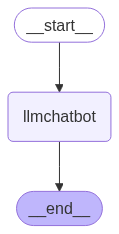

In [14]:
from IPython.display import display, Image

Image(graph.get_graph().draw_mermaid_png())

In [15]:
response=graph.invoke({"messages":"who is the father of bottle"})
print(response)
print("\n")
print(type(response))
print("\n")
print(response["messages"][-1])
print("\n")
print(response["messages"][-1].content)
print("\n")
for m in response["messages"]:
    m.pretty_print()

{'messages': [HumanMessage(content='who is the father of bottle', additional_kwargs={}, response_metadata={}, id='a82720fb-e57f-46cb-abe7-808d253f5b2d'), AIMessage(content='It\'s impossible to say who the "father of the bottle" is! \n\nThe bottle, as a vessel for holding liquids, has a very long history, evolving over thousands of years. \n\nHere\'s why we can\'t pinpoint a single inventor:\n\n* **Ancient Origins:**  Early forms of bottles were made from materials like clay, stone, and even animal bladders. These were developed independently in various cultures around the world.\n* **Gradual Evolution:** The design of bottles changed gradually over time, with innovations like glassblowing, cork stoppers, and different shapes being introduced at various stages.\n* **Many Contributors:** Countless artisans, inventors, and craftsmen contributed to the development of the bottle as we know it today.\n\nInstead of a single "father," think of the bottle\'s invention as a long and fascinating 